In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

# Use GPU if it is present
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
batch_size = 500

# https://www.kaggle.com/beastlyprime/pytorch-beginner-transfer-learning
transform = transforms.Compose([
        transforms.Resize(325),
        transforms.CenterCrop(299), # Note that we want to use Inception v3, it requires this size of images
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Split train data into training and valdation test sets
# https://stackoverflow.com/questions/57789645/torch-utils-data-random-split-is-not-splitting-the-data
train_size = int(0.8*len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_data,batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class Train():
  def __init__(self, name, model, optimizer, loss_fn, train_loader, val_loader, epochs):
    self.name = name
    self.model = model
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.train_loader = train_loader
    self.val_loader = val_loader

    self.epochs = epochs
    self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  def train_val(self):
    self.best_val_loss = float('inf')
    
    self.train_losses = []
    self.train_accuracies = []

    self.val_losses = []
    self.val_accuracies = []

    for epoch in range(self.epochs):
      start_time = time.monotonic()

      self.train_loss, self.train_accuracy = self.train()
      self.val_loss, self.val_accuracy = self.evaluate()

      if self.val_loss < self.best_val_loss:
        best_val_loss = self.val_loss
        torch.save(self.model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/Validation_state/'+self.name+'.pth')

      self.train_losses.append(self.train_loss)
      self.train_accuracies.append(self.train_accuracy)

      self.val_losses.append(self.val_loss)
      self.val_accuracies.append(self.val_accuracy)

      end_time = time.monotonic()

      epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {self.train_loss:.3f} | Train Acc: {self.train_accuracy*100:.2f}%')
      print(f'\tVal.  Loss: {self.val_loss:.3f} | Val. Acc: {self.val_accuracy*100:.2f}%')
      print("="*75)

    self.save()

  def save(self):
    df = pd.DataFrame()

    df['Train Loss'] = self.train_losses
    df['Train Accracy'] = self.train_accuracies

    df['Validation Loss'] = self.val_losses
    df['Validation Accuracy'] = self.val_accuracies

    df.to_csv('/content/drive/MyDrive/Colab Notebooks/Saved_CSV/'+self.name+'.csv')
    
  def train(self):
    avg_losses = []
    avg_accuracies = []
    for i, data in enumerate(self.train_loader):
      inputs, labels = data[0].to(self.device), data[1].to(self.device)

      self.optimizer.zero_grad()

      y_pred, aux_outputs = self.model(inputs)
      loss1 = self.loss_fn(y_pred, labels)
      loss2 = self.loss_fn(aux_outputs, labels)
      loss = loss1 + 0.4*loss2
      loss.backward()
      self.optimizer.step()

      y_pred = y_pred.argmax(1)
      accuracy = accuracy_score(labels.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
      
      avg_losses.append(loss.item())
      avg_accuracies.append(accuracy)

    avg_loss = sum(avg_losses) / len(avg_losses)
    avg_accuracy = sum(avg_accuracies) / len(avg_accuracies)
    
    return avg_loss, avg_accuracy

  def evaluate(self):
    avg_losses = []
    avg_accuracies = []

    with torch.no_grad():
      for i, data in enumerate(val_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        y_pred = self.model(inputs)
        # https://discuss.pytorch.org/t/error-in-training-inception-v3/23933/8
        loss = self.loss_fn(y_pred.logits, labels)
        accuracy = accuracy_score(labels.cpu().detach().numpy(), y_pred.logits.argmax(1).cpu().detach().numpy())

        avg_losses.append(loss.item())
        avg_accuracies.append(accuracy)

    avg_loss = sum(avg_losses) / len(avg_losses)
    avg_accuracy = sum(avg_accuracies) / len(avg_accuracies)

    return avg_loss, avg_accuracy

  def test(self, best_model, test_loader):
    avg_losses = []
    avg_accuracies = []

    with torch.no_grad():
      for i, data in enumerate(test_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        y_pred = best_model(inputs)
        loss = self.loss_fn(y_pred.logits, labels)
        accuracy = accuracy_score(labels.cpu().detach().numpy(), y_pred.logits.argmax(1).cpu().detach().numpy())

        avg_losses.append(loss.item())
        avg_accuracies.append(accuracy)

    avg_loss = sum(avg_losses) / len(avg_losses)
    avg_accuracy = sum(avg_accuracies) / len(avg_accuracies)

    return avg_loss, avg_accuracy

  def epoch_time(self, start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

  def loss_plot(self):
    Epochs = [i for i in range(self.epochs)]
    plt.plot(Epochs, self.train_losses,'r', label="Training loss")
    plt.plot(Epochs, self.val_losses,'g', label="Validation loss")
    plt.legend()
    plt.show()

  def accuracy_plot(self):
    Epochs = [i for i in range(self.epochs)]
    multiplied_list = [element * 100 for element in self.train_accuracies]
    multiplied_list1 = [element * 100 for element in self.val_accuracies]
    plt.plot(Epochs, multiplied_list,'r', label="Training Accuracy")
    plt.plot(Epochs, multiplied_list1,'g', label="Validation Accuracy")
    plt.legend()
    plt.show()

  def save_model(self):
    PATH = '/content/drive/MyDrive/Colab Notebooks/'+self.name+'_cifar10.pth'
    torch.save(self.model.state_dict(), PATH)

In [5]:
model = models.inception_v3(pretrained=True)
# Freeze all the layers weights to speed up the learning
for parameter in model.parameters():
  parameter.requires_grad = False
# Change the final layer to no. of output dimensions
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 10)
# Handle the primary net
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

lr = 5e-4
epochs = 50
optimizer = optim.Adam(params = model.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()

model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [6]:
epochs = 10
googlenet = Train(name="inceptionv3",model=model,optimizer=optimizer,loss_fn=loss_fn,train_loader=train_loader,val_loader=val_loader,epochs=epochs)
googlenet.train_val()

Epoch: 01 | Epoch Time: 4m 8s
	Train Loss: 2.232 | Train Acc: 51.51%
	Val.  Loss: 1.262 | Val. Acc: 63.67%
Epoch: 02 | Epoch Time: 4m 6s
	Train Loss: 1.503 | Train Acc: 66.00%
	Val.  Loss: 1.059 | Val. Acc: 66.69%
Epoch: 03 | Epoch Time: 4m 6s
	Train Loss: 1.332 | Train Acc: 67.69%
	Val.  Loss: 0.972 | Val. Acc: 68.64%
Epoch: 04 | Epoch Time: 4m 8s
	Train Loss: 1.259 | Train Acc: 68.72%
	Val.  Loss: 0.945 | Val. Acc: 68.81%
Epoch: 05 | Epoch Time: 4m 6s
	Train Loss: 1.209 | Train Acc: 69.42%
	Val.  Loss: 0.918 | Val. Acc: 69.48%
Epoch: 06 | Epoch Time: 4m 6s
	Train Loss: 1.177 | Train Acc: 70.01%
	Val.  Loss: 0.898 | Val. Acc: 70.04%
Epoch: 07 | Epoch Time: 4m 6s
	Train Loss: 1.155 | Train Acc: 70.23%
	Val.  Loss: 0.891 | Val. Acc: 69.57%
Epoch: 08 | Epoch Time: 4m 6s
	Train Loss: 1.141 | Train Acc: 70.58%
	Val.  Loss: 0.882 | Val. Acc: 70.01%
Epoch: 09 | Epoch Time: 4m 7s
	Train Loss: 1.130 | Train Acc: 70.36%
	Val.  Loss: 0.873 | Val. Acc: 70.69%
Epoch: 10 | Epoch Time: 4m 8s
	Train 

In [11]:
train_losses, train_accuracies = googlenet.train_losses, googlenet.train_accuracies
val_losses, val_accuracies = googlenet.val_losses, googlenet.val_accuracies

In [12]:
googlenet.train_val()

Epoch: 01 | Epoch Time: 4m 8s
	Train Loss: 1.109 | Train Acc: 70.78%
	Val.  Loss: 0.871 | Val. Acc: 70.21%
Epoch: 02 | Epoch Time: 4m 6s
	Train Loss: 1.098 | Train Acc: 71.27%
	Val.  Loss: 0.875 | Val. Acc: 70.18%
Epoch: 03 | Epoch Time: 4m 6s
	Train Loss: 1.097 | Train Acc: 71.22%
	Val.  Loss: 0.867 | Val. Acc: 70.92%
Epoch: 04 | Epoch Time: 4m 7s
	Train Loss: 1.087 | Train Acc: 71.23%
	Val.  Loss: 0.859 | Val. Acc: 70.73%
Epoch: 05 | Epoch Time: 4m 6s
	Train Loss: 1.086 | Train Acc: 71.13%
	Val.  Loss: 0.860 | Val. Acc: 70.45%
Epoch: 06 | Epoch Time: 4m 5s
	Train Loss: 1.078 | Train Acc: 71.50%
	Val.  Loss: 0.856 | Val. Acc: 70.63%
Epoch: 07 | Epoch Time: 4m 7s
	Train Loss: 1.076 | Train Acc: 71.39%
	Val.  Loss: 0.864 | Val. Acc: 70.81%
Epoch: 08 | Epoch Time: 4m 7s
	Train Loss: 1.072 | Train Acc: 71.54%
	Val.  Loss: 0.855 | Val. Acc: 70.56%
Epoch: 09 | Epoch Time: 4m 7s
	Train Loss: 1.069 | Train Acc: 71.61%
	Val.  Loss: 0.854 | Val. Acc: 70.74%
Epoch: 10 | Epoch Time: 4m 8s
	Train 

In [13]:
train_losses.extend(googlenet.train_losses)
train_accuracies.extend(googlenet.train_accuracies)

val_losses.extend(googlenet.val_losses)
val_accuracies.extend(googlenet.val_accuracies)

In [16]:
df = pd.DataFrame()

df['Train Loss'] = train_losses
df['Train Accracy'] = train_accuracies

df['Validation Loss'] = val_losses
df['Validation Accuracy'] = val_accuracies

df.to_csv('/content/drive/MyDrive/Colab Notebooks/Saved_CSV/inceptionv3.csv')

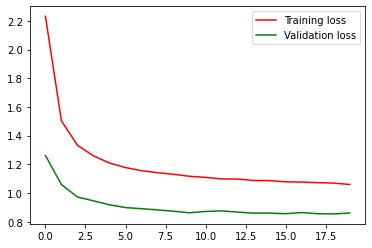

In [17]:
Epochs = [i for i in range(20)]
plt.plot(Epochs, train_losses,'r', label="Training loss")
plt.plot(Epochs, val_losses,'g', label="Validation loss")
plt.legend()
plt.show()

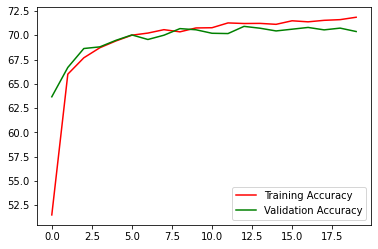

In [19]:
Epochs = [i for i in range(20)]
multiplied_list = [element * 100 for element in train_accuracies]
multiplied_list1 = [element * 100 for element in val_accuracies]
plt.plot(Epochs, multiplied_list,'r', label="Training Accuracy")
plt.plot(Epochs, multiplied_list1,'g', label="Validation Accuracy")
plt.legend()
plt.show()

In [7]:
best_model = models.inception_v3(pretrained=True)
# Change the final layer to no. of output dimensions
# Change the final layer to no. of output dimensions
num_ftrs = best_model.AuxLogits.fc.in_features
best_model.AuxLogits.fc = nn.Linear(num_ftrs, 10)
# Handle the primary net
num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, 10)

best_model.to(device)
best_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Validation_state/inceptionv3.pth'))

lr = 5e-4
epochs = 50
optimizer = optim.Adam(params = best_model.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
googlenet = Train(name="inceptionv3",model=best_model,optimizer=optimizer,loss_fn=loss_fn,train_loader=train_loader,val_loader=val_loader,epochs=epochs)

test_loss, test_accuracy = googlenet.test(best_model, test_loader)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_accuracy*100:.2f}%')

Test Loss: 0.856 | Test Acc: 70.27%


In [26]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        i = 0
        for (x, y) in iterator:
            print("iteration ",i)
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            # y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_pred.argmax(1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_pred.cpu())

            i += 1

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

In [ ]:
images, labels, probs = get_predictions(best_model, test_loader)
pred_labels = torch.argmax(probs, 1)
classes = test_data.classes
plot_confusion_matrix(labels, pred_labels, classes)

iteration  0
iteration  1
iteration  2
iteration  3
iteration  4


In [ ]:
print(f'{classification_report(labels, pred_labels)}')